### Подготовка данных

In [92]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, transform=None):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        super(CocoDetection, self).__init__(img_folder, ann_file, transform=transform)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img, annotations=target, return_tensors="pt")

        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target

In [93]:
checkpoint  = "hustvl/yolos-small"

In [94]:
from transformers import YolosImageProcessor 

image_processor= YolosImageProcessor.from_pretrained(checkpoint, format="coco_detection", size=480)

In [95]:
!pip install pycocotools

In [96]:
import torchvision.transforms 

train_dataset = CocoDetection("./train", image_processor, torchvision.transforms .Resize(480))
val_dataset = CocoDetection("./valid", image_processor,torchvision.transforms .Resize(480))
test_dataset = CocoDetection("./test", image_processor)

print()
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Number of training examples: 1698
Number of validation examples: 173
Number of test examples: 181


Image № 1695


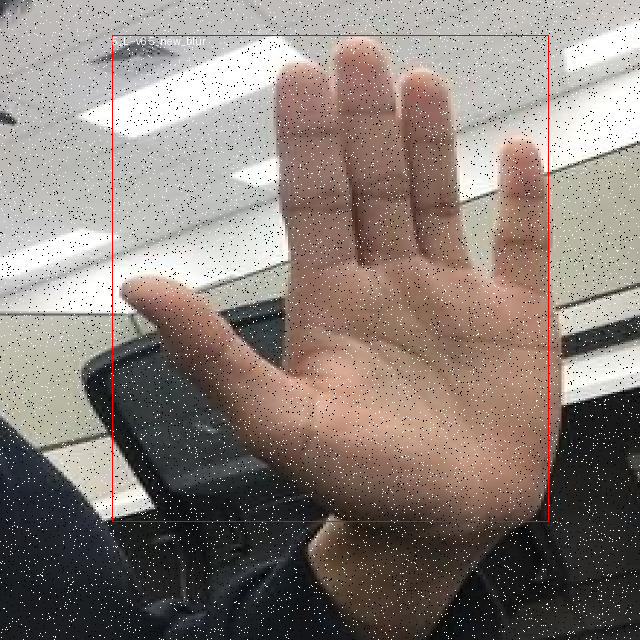

In [141]:
import numpy as np
import os
from PIL import Image, ImageDraw

image_ids = train_dataset.coco.getImgIds()
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image № {}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(train_dataset.root, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [98]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = image_processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(train_dataloader))

In [99]:
!pip install pytorch_lightning

## Train

In [100]:
import pytorch_lightning as pl
from transformers import AutoModelForObjectDetection
import torch

class YoloS(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained(checkpoint, 
                                                                  num_labels=len(id2label),
                                                                  ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay
         self.save_hyperparameters()

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx) 
        self.log("train/loss", loss) 
        for k,v in loss_dict.items():
          self.log("train/" + k, v.item())  

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k,v in loss_dict.items():
          self.log("validation/" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [101]:
model = YoloS(lr=1e-5, weight_decay=1e-4)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint


wandb_logger = WandbLogger(project='Ship-detection', log_model=True)
checkpoint_callback = ModelCheckpoint(monitor="validation/loss", mode="min")

In [103]:
torch.cuda.is_available()

True

In [104]:
from pytorch_lightning import Trainer


trainer = Trainer(max_epochs=100, 
                  gradient_clip_val=0.1, 
                  accumulate_grad_batches=16, 
                  log_every_n_steps=1, 
                  logger=wandb_logger, 
                  callbacks=[checkpoint_callback])

trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pdd\PycharmProjects\detect\venv\lib\site-packages\pytorch_lightning\loggers\wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | YolosForObjectDetection | 30.7 M
--------------------------------------------------
30.7 M    Trainable params
0         Non-trainable params
30.7 M    Total params
122.604   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [113]:
torch.save(model.state_dict(), "model.pt")

***

## Evaluate

In [106]:
!git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...


In [114]:
model = YoloS(lr=1e-5, weight_decay=1e-4)
model.load_state_dict(torch.load("model.pt"))
model.eval()

model.to(torch.device('cuda'))

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


YoloS(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosSdpaAttention(
              (attention): YolosSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropou

In [115]:
from detr.datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset)

In [116]:
from detr.datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    pixel_values = batch["pixel_values"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    outputs = model.model(pixel_values=pixel_values)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process(outputs, orig_target_sizes)
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/87 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.442
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.208
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.506
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.539
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

***

## Visualize

In [161]:
import torch
import matplotlib.pyplot as plt

CONFIDENCE=0.9

COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=8,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), (480, 480))
  plot_results(image, probas[keep], bboxes_scaled)


In [162]:
pixel_values, target = test_dataset[5]
pixel_values = pixel_values.unsqueeze(0).to(torch.device("cuda"))

outputs = model(pixel_values=pixel_values)

Image:  IMG_8341_jpg.rf.08f5c8ac248e54a65aea89daefe42bb7.jpg


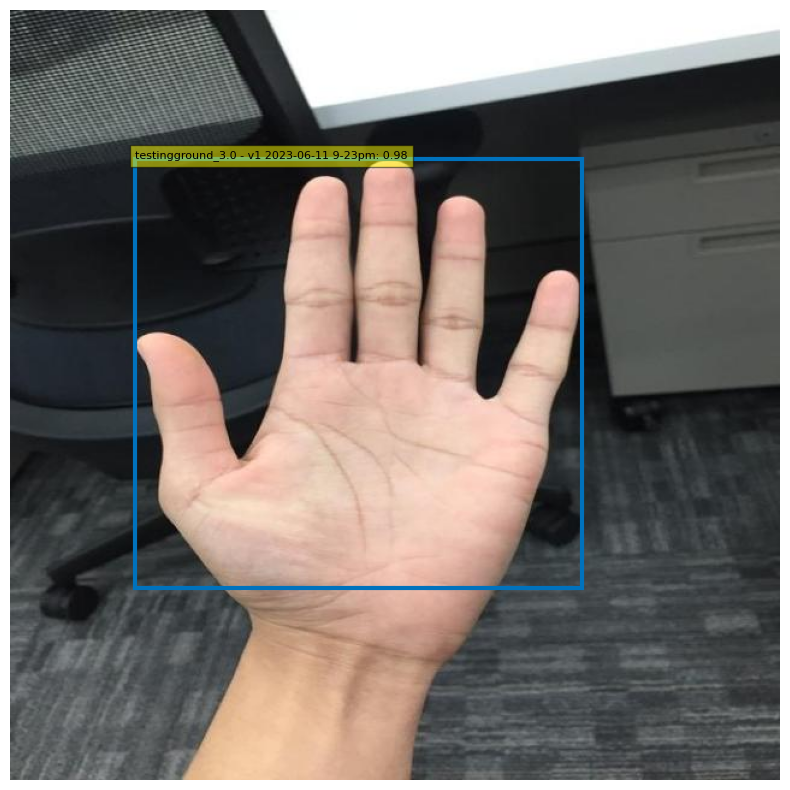

In [171]:
image_id = target['image_id'].item()

image = test_dataset.coco.loadImgs(image_id)[0]
image_filename = image['file_name']
image = Image.open(os.path.join('./test', image_filename))

print("Image: ", image_filename)
visualize_predictions(image, outputs)